In [0]:
  !wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

--2025-01-15 20:36:07--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.32, 52.95.154.82
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv.3’

bitcoin_tweets.csv. 100%[===================>]  23.56M  11.0MB/s    in 2.1s    

2025-01-15 20:36:10 (11.0 MB/s) - ‘bitcoin_tweets.csv.3’ saved [24708828/24708828]



In [0]:
pip install textblob


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install yfinance

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, date_format, count, avg, to_date
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from textblob import TextBlob
import yfinance as yf
import matplotlib.dates as mdates
import numpy as np

In [0]:
# Crea una sessione Spark
spark = SparkSession.builder.appName("Bitcoin Sentiment Analysis").getOrCreate()

# Leggi il file CSV con Pandas e crea un DataFrame Spark
dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv')
spark_df = spark.createDataFrame(dataset)


In [0]:
# Preprocessamento dei dati
spark_df = spark_df.withColumn("text", lower(col("text")))
spark_df = spark_df.withColumn("text", regexp_replace(col("text"), r"http\S+|www\S+|https\S+|@\w+|[^a-zA-Z\s]", ""))


al fine di poter svolgere la sentiment analysis è necessario pulire il testo dei tweet trasformandolo tutto in minuscolo e rimuovendo URL, menzioni e caratteri speciali

In [0]:
# Funzione per calcolare il sentiment
def analyze_sentiment(text):
    if text is None or text.strip() == "":
        return "neutral"
    polarity = TextBlob(text).sentiment.polarity
    return "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"

In [0]:
# Registra la funzione come UDF e applicala
sentiment_udf = F.udf(analyze_sentiment, StringType())
spark_df = spark_df.withColumn("sentiment", sentiment_udf(col("text")))


In [0]:
# Estrai la data dal timestamp
spark_df = spark_df.withColumn("date", to_date(col("timestamp")))

In [0]:
# Filtra i dati per mantenere solo quelli nell'intervallo di date desiderato
spark_df = spark_df.filter((col("date") >= "2017-01-01") & (col("date") <= "2019-12-31"))

In [0]:
# Raggruppa i dati
daily_sentiment_df = spark_df.groupBy("date", "sentiment").agg(count("sentiment").alias("count"))


In [0]:
# Pivot per ottenere le colonne positive, negative, neutral
daily_sentiment_pivot = daily_sentiment_df.groupBy("date").pivot("sentiment", ["positive", "negative", "neutral"]).sum("count").fillna(0)

# Calcola il sentiment score
daily_sentiment_pivot = daily_sentiment_pivot.withColumn("sentiment_score", col("positive") - col("negative"))

# Converti in Pandas DataFrame
sentiment_df = daily_sentiment_pivot.select("date", "positive", "negative", "neutral", "sentiment_score").toPandas()

In [0]:
# Controlla se la colonna 'sentiment_score' esiste
if 'sentiment_score' not in sentiment_df.columns:
    print("La colonna 'sentiment_score' non esiste nel DataFrame Pandas.")
else:
    print(sentiment_df.head())

         date  positive  negative  neutral  sentiment_score
0  2019-05-08        73        23       84               50
1  2018-05-28         0         0        2                0
2  2018-08-10         3         0        2                3
3  2018-03-17         1         0        1                1
4  2018-06-06         0         0        3                0


con lo svolgimento della sentiment analysis nel dataframe troviamo 3 colonne che contano la presenza di tweetcon sentiment rispettivamente: positivo, negativo o neutro, inoltre troviamo una colonna con il sentiment score che ci servirà per valutare l'andamento dello stesso nel tempo e di poterlo poi confrontare con l'andamento del prezzo dei BTC

In [0]:
# Eliminare gli outliers basati su sentiment_score utilizzando IQR
Q1 = sentiment_df['sentiment_score'].quantile(0.25)
Q3 = sentiment_df['sentiment_score'].quantile(0.75)
IQR = Q3 - Q1

# Filtra gli outlier
sentiment_df = sentiment_df[~((sentiment_df['sentiment_score'] < (Q1 - 1.5 * IQR)) | (sentiment_df['sentiment_score'] > (Q3 + 1.5 * IQR)))]

eliminiamo gli outliers al fine di non falsare la statistica

In [0]:
# Cambia la colonna 'date' in formato datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [0]:
# Raggruppa i sentimenti mensilmente
monthly_sentiment_df = sentiment_df.resample('M', on='date').sum()

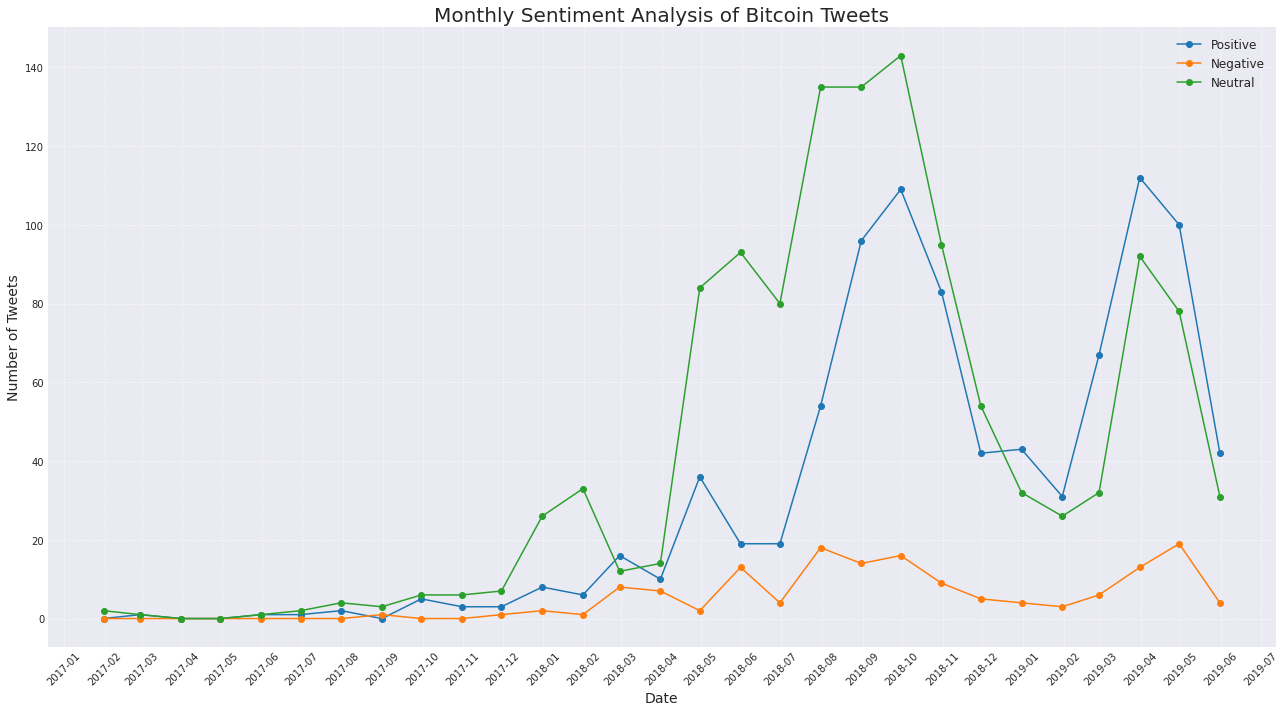

In [0]:
# Grafico temporale mensile dei sentimenti
plt.figure(figsize=(18, 10))
plt.style.use('seaborn-darkgrid')

# Disegnare le linee per ciascun sentimento
for sentiment in ['positive', 'negative', 'neutral']:
    plt.plot(monthly_sentiment_df.index, monthly_sentiment_df[sentiment], marker='o', linestyle='-', label=sentiment.capitalize())

# Aggiungere titolo e etichette
plt.title('Monthly Sentiment Analysis of Bitcoin Tweets', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)

# Aggiungere griglia
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Ruotare le etichette delle date
plt.xticks(rotation=45)

# Impostare il formato dell'asse delle x per le date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Aggiungere legenda
plt.legend(fontsize=12)

# Migliorare il layout
plt.tight_layout()

# Mostrare il grafico
plt.show()

il grafico ci dice che tra i tweet analizzati generalmente prevalgono sentimenti neutrali, anche se negli ultimi mesi analizzati c'è una crescita di quelli positivi. I tweet con sentimenti negativi sono rimasti sempre un numero basso.

In [0]:
# Calcola e confronta le medie di likes e risposte
for sentiment in ['positive', 'negative']:
    avg_likes = spark_df.filter(spark_df.sentiment == sentiment).agg(avg('likes')).collect()[0][0]
    avg_replies = spark_df.filter(spark_df.sentiment == sentiment).agg(avg('replies')).collect()[0][0]
    print(f"Average likes for {sentiment} tweets: {avg_likes:.2f}")
    print(f"Average replies for {sentiment} tweets: {avg_replies:.2f}")

Average likes for positive tweets: 9.65
Average replies for positive tweets: 1.31
Average likes for negative tweets: 10.48
Average replies for negative tweets: 1.22


Per quanto riguarda le medie dei like e delle risposte, non c'è una differenza significativa tra i due nei tweet con sentimento positivo e quelli con sentimento negativo

In [0]:
# Scarica dati storici del Bitcoin
btc_data = yf.download('BTC-USD', start='2017-01-01', end='2019-12-31')
btc_data.reset_index(inplace=True)
btc_data['date'] = btc_data['Date'].dt.strftime('%Y-%m-%d')
print(btc_data.head())


[*********************100%%**********************]  1 of 1 completed
        Date         Open         High          Low        Close    Adj Close  \
0 2017-01-01   963.658020  1003.080017   958.698975   998.325012   998.325012   
1 2017-01-02   998.617004  1031.390015   996.702026  1021.750000  1021.750000   
2 2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  1043.839966   
3 2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  1154.729980   
4 2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  1013.380005   

      Volume        date  
0  147775008  2017-01-01  
1  222184992  2017-01-02  
2  185168000  2017-01-03  
3  344945984  2017-01-04  
4  510199008  2017-01-05  


In [0]:
# Calcola la variazione giornaliera del prezzo del Bitcoin
btc_data['price_change'] = btc_data['Close'].pct_change()



In [0]:
# Assicurati che entrambe le colonne 'date' siano di tipo datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
btc_data['date'] = pd.to_datetime(btc_data['date'])

In [0]:
# Unisci i dati dei sentiment con i dati del prezzo del Bitcoin
merged_df = pd.merge(sentiment_df, btc_data[['date', 'price_change']], on='date', how='inner')

In [0]:
# Pivot per ottenere le colonne positive, negative, neutral
daily_sentiment_pivot = daily_sentiment_df.groupBy("date").pivot("sentiment", ["positive", "negative", "neutral"]).sum("count").fillna(0)

# Calcola il sentiment score
daily_sentiment_pivot = daily_sentiment_pivot.withColumn("sentiment_score", col("positive") - col("negative"))

# Assicurati che sentiment_score sia presente
print(daily_sentiment_pivot.show())

# Converti in Pandas DataFrame
sentiment_df = daily_sentiment_pivot.select("date", "positive", "negative", "neutral", "sentiment_score").toPandas()

# Verifica il contenuto di sentiment_df
print(sentiment_df.head())


+----------+--------+--------+-------+---------------+
|      date|positive|negative|neutral|sentiment_score|
+----------+--------+--------+-------+---------------+
|2019-05-08|      73|      23|     84|             50|
|2018-05-28|       0|       0|      2|              0|
|2018-08-10|       3|       0|      2|              3|
|2018-03-17|       1|       0|      1|              1|
|2018-06-06|       0|       0|      3|              0|
|2018-08-08|       1|       0|      1|              1|
|2018-06-26|       1|       0|      3|              1|
|2018-11-02|       3|       0|      1|              3|
|2018-09-09|       3|       0|      2|              3|
|2018-09-01|       2|       0|      9|              2|
|2018-08-11|       3|       0|      6|              3|
|2018-10-05|       3|       0|      3|              3|
|2017-01-27|       0|       0|      1|              0|
|2019-05-27|     709|     147|   1450|            562|
|2018-06-30|       0|       0|      5|              0|
|2019-02-2

In [0]:
# Esempio di dati
data = {
    'sentiment_score': [0.1, 0.2, np.nan, -0.1, 0.3],
    'price_change': [0.01, -0.05, 0.02, np.nan, 0.07]
}

# Creazione di un DataFrame Pandas
df = pd.DataFrame(data)

# Rimozione di righe con valori nulli
df_clean = df.dropna()

# Calcolo della correlazione
correlation = df_clean['sentiment_score'].corr(df_clean['price_change'])
print(f"Correlation between sentiment score and price change: {correlation:.2f}")


Correlation between sentiment score and price change: 0.50


In [0]:
# Determina il tipo di correlazione
if correlation > 0.5:
    print("There is a strong positive correlation. The sentiment score and Bitcoin price change influence each other positively.")
elif correlation < -0.5:
    print("There is a strong negative correlation. The sentiment score and Bitcoin price change influence each other negatively.")
else:
    print("There is little to no correlation. The sentiment score and Bitcoin price change do not significantly influence each other.")


There is little to no correlation. The sentiment score and Bitcoin price change do not significantly influence each other.


Il calcolo della correlazione tra la variazione dei prezzi dei BTC e il sentiment score dei tweet ci dice che tra le due variabili c'è una leggera correlazione positiva
